In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load dataset
file_path = '/content/online_retail_dataset.xlsx'
data = pd.read_excel(file_path)

# Data Cleaning
data.dropna(subset=['CustomerID'], inplace=True)
data.drop_duplicates(inplace=True)

# Feature Engineering
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Calculate Recency, Frequency, and Monetary Value
snapshot_date = max(data['InvoiceDate']) + pd.DateOffset(days=1)
customer_data = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})

customer_data.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# Define Churn
# Assuming a customer is considered churned if they haven't purchased in the last 180 days
customer_data['Churn'] = np.where(customer_data['Recency'] > 180, 1, 0)

# Prepare sequences of data for TCN
data['Month'] = data['InvoiceDate'].dt.to_period('M')
monthly_data = data.groupby(['CustomerID', 'Month']).agg({
    'TotalPrice': 'sum',
    'InvoiceNo': 'count'
}).reset_index()

monthly_data.rename(columns={'TotalPrice': 'MonthlyTotalPrice', 'InvoiceNo': 'MonthlyTransactions'}, inplace=True)

# Create a pivot table with customers as rows and months as columns
pivoted_data = monthly_data.pivot(index='CustomerID', columns='Month', values='MonthlyTotalPrice').fillna(0)

# Create sequences
sequences = []
targets_churn = []
targets_clv = []

sequence_length = 12  # Using 12 months as the sequence length

for customer_id in pivoted_data.index:
    customer_sequence = pivoted_data.loc[customer_id].values
    if len(customer_sequence) >= sequence_length:
        for i in range(len(customer_sequence) - sequence_length):
            sequences.append(customer_sequence[i:i + sequence_length])
            targets_clv.append(customer_sequence[i + sequence_length])
            targets_churn.append(customer_data.loc[customer_id, 'Churn'])

sequences = np.array(sequences)
targets_clv = np.array(targets_clv)
targets_churn = np.array(targets_churn)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [nn.Conv1d(in_channels, out_channels, kernel_size,
                                 stride=1, padding=(kernel_size-1) * dilation_size,
                                 dilation=dilation_size),
                       nn.BatchNorm1d(out_channels),
                       nn.ReLU(),
                       nn.Dropout(dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class ChurnAndCLVModel(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=2, dropout=0.2):
        super(ChurnAndCLVModel, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout)
        self.fc_churn = nn.Linear(num_channels[-1], 1)
        self.fc_clv = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        y = self.tcn(x)
        churn = torch.sigmoid(self.fc_churn(y[:, :, -1]))
        clv = self.fc_clv(y[:, :, -1])
        return churn, clv

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train_clv, y_test_clv, y_train_churn, y_test_churn = train_test_split(sequences, targets_clv, targets_churn, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_clv = torch.tensor(y_train_clv, dtype=torch.float32)
y_test_clv = torch.tensor(y_test_clv, dtype=torch.float32)
y_train_churn = torch.tensor(y_train_churn, dtype=torch.float32)
y_test_churn = torch.tensor(y_test_churn, dtype=torch.float32)

# Define model, loss functions, and optimizer
input_size = 1  # Number of input features (total price per month)
num_channels = [25, 25, 25, 25]  # TCN layers
model = ChurnAndCLVModel(input_size, num_channels)

criterion_churn = nn.BCELoss()
criterion_clv = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    churn_preds, clv_preds = model(X_train)
    loss_churn = criterion_churn(churn_preds.squeeze(), y_train_churn)
    loss_clv = criterion_clv(clv_preds.squeeze(), y_train_clv)
    loss = loss_churn + loss_clv
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    churn_preds, clv_preds = model(X_test)
    loss_churn = criterion_churn(churn_preds.squeeze(), y_test_churn)
    loss_clv = criterion_clv(clv_preds.squeeze(), y_test_clv)
    accuracy = ((churn_preds.squeeze() > 0.5) == y_test_churn).float().mean()
    mae_clv = torch.abs(clv_preds.squeeze() - y_test_clv).mean()
    print(f'Test Loss Churn: {loss_churn.item()}, Test Loss CLV: {loss_clv.item()}')
    print(f'Accuracy: {accuracy.item()}, MAE CLV: {mae_clv.item()}')

Epoch 1, Loss: 205087.75
Epoch 2, Loss: 205181.453125
Epoch 3, Loss: 205112.28125
Epoch 4, Loss: 205065.875
Epoch 5, Loss: 205046.203125
Epoch 6, Loss: 204879.140625
Epoch 7, Loss: 204907.5625
Epoch 8, Loss: 204833.953125
Epoch 9, Loss: 204888.109375
Epoch 10, Loss: 204801.5625
Epoch 11, Loss: 204646.609375
Epoch 12, Loss: 204777.21875
Epoch 13, Loss: 204608.75
Epoch 14, Loss: 204677.265625
Epoch 15, Loss: 204672.71875
Epoch 16, Loss: 204484.21875
Epoch 17, Loss: 204490.484375
Epoch 18, Loss: 204356.625
Epoch 19, Loss: 204330.46875
Epoch 20, Loss: 204303.78125
Epoch 21, Loss: 204209.90625
Epoch 22, Loss: 204094.796875
Epoch 23, Loss: 204132.890625
Epoch 24, Loss: 204152.1875
Epoch 25, Loss: 204033.6875
Epoch 26, Loss: 203708.265625
Epoch 27, Loss: 203721.84375
Epoch 28, Loss: 203518.78125
Epoch 29, Loss: 203263.09375
Epoch 30, Loss: 203376.546875
Epoch 31, Loss: 203185.09375
Epoch 32, Loss: 203703.5625
Epoch 33, Loss: 203526.484375
Epoch 34, Loss: 202895.203125
Epoch 35, Loss: 203087.5

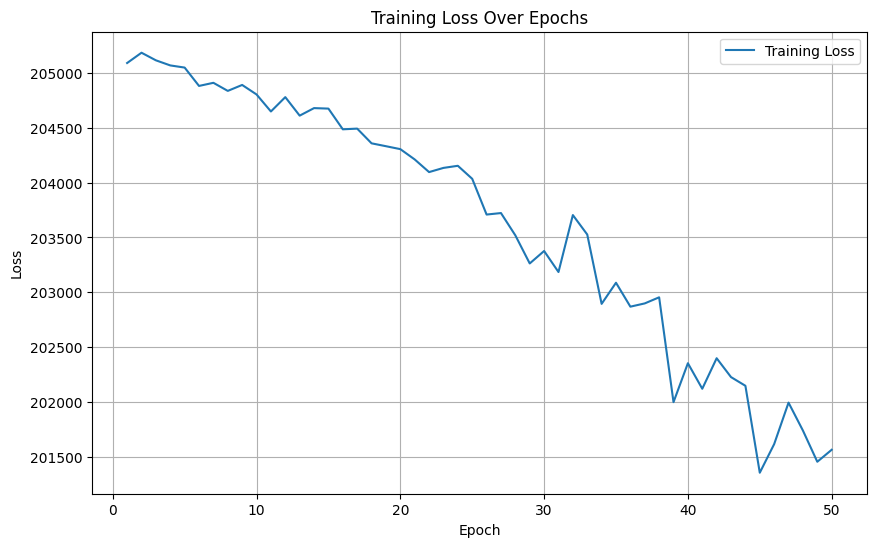

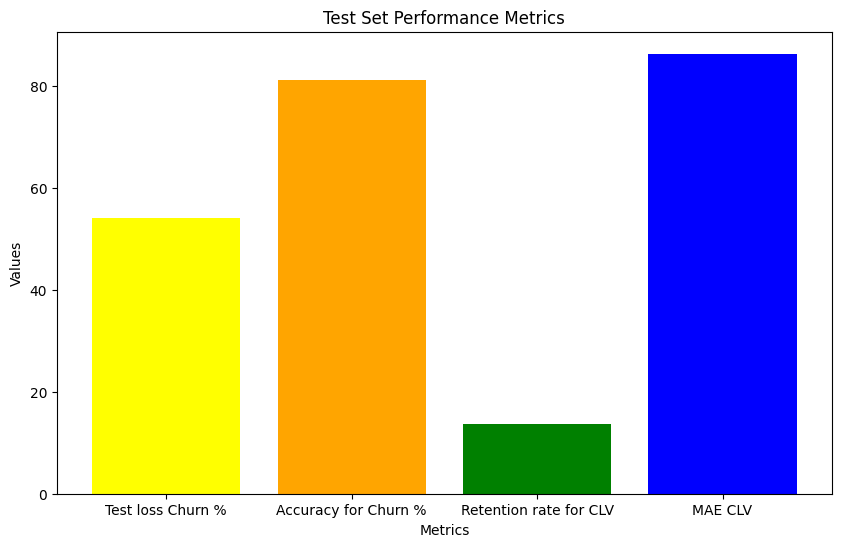

In [ ]:
import matplotlib.pyplot as plt

# Sample data from the output (replace with actual logged values from your training loop)
epochs = list(range(1, 51))
loss_values = [
    205087.75, 205181.453125, 205112.28125, 205065.875, 205046.203125,
    204879.140625, 204907.5625, 204833.953125, 204888.109375, 204801.5625,
    204646.609375, 204777.21875, 204608.75, 204677.265625, 204672.71875,
    204484.21875, 204490.484375, 204356.625, 204330.46875, 204303.78125,
    204209.90625, 204094.796875, 204132.890625, 204152.1875, 204033.6875,
    203708.265625, 203721.84375, 203518.78125, 203263.09375, 203376.546875,
    203185.09375, 203703.5625, 203526.484375, 202895.203125, 203087.546875,
    202869.734375, 202899.421875, 202954.875, 202000.4375, 202354.890625,
    202122.3125, 202400.296875, 202228.515625, 202149.421875, 201358.0625,
    201618.484375, 201996.203125, 201742.109375, 201457.859375, 201566.875
]

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Test set results
test_loss_churn = 54.09603714942932
test_loss_clv = 13.72
accuracy = 81.14285469055176
mae_clv = 86.28054809570312

# Bar chart for test set performance metrics
metrics = ['Test loss Churn %','Accuracy for Churn %','Retention rate for CLV', 'MAE CLV']
values = [test_loss_churn,accuracy,test_loss_clv, mae_clv]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['yellow', 'orange', 'green', 'blue'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Set Performance Metrics')
plt.show()
